In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import skimage.io
from sklearn.utils import shuffle
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Dropout, MaxPool2D, Flatten, Dense
# from keras_tqdm import TQDMNotebookCallback
from tqdm import tqdm

!pip install -U --pre efficientnet
import efficientnet.tfkeras as efn

Requirement already up-to-date: efficientnet in /opt/conda/lib/python3.7/site-packages (1.1.0)


In [4]:
print("Num GPUs:", len(tf.config.list_physical_devices('GPU')), tf.config.list_physical_devices('GPU'))

DF = pd.read_csv('/home/surajkhetarpal/Original_DF.csv')
np.random.seed(31415)
shuffle(DF).reset_index(drop=True, inplace=True)

source_images_dir = '/home/surajkhetarpal/train_images/'

tiles_dir = '/home/jupyter/panda/images'

tile_size = 256
num_tiles = 48
channels = 3

DF.head()

Num GPUs: 1 [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


,Unnamed: 0,image_id,data_provider,isup_grade,gleason_score
0,0,0005f7aaab2800f6170c399693a96917,karolinska,0,0+0
1,1,000920ad0b612851f8e01bcc880d9b3d,karolinska,0,0+0
2,2,0018ae58b01bdadc8e347995b69f99aa,radboud,4,4+4
3,3,001c62abd11fa4b57bf7a6c603a11bb9,karolinska,4,4+4
4,4,001d865e65ef5d2579c190a0e0350d8f,karolinska,0,0+0


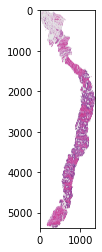

In [5]:
image_id = DF.image_id.loc[0]
label = DF.isup_grade.loc[0]
image_file = f'{source_images_dir}{image_id}_1.jpeg'
image = skimage.io.imread(image_file).astype(np.uint8)
plt.imshow(image); plt.show()

In [3]:
def add_padding(image, tile_size):
    pad0 = (tile_size - image.shape[0]%tile_size)
    pad1 = (tile_size - image.shape[1]%tile_size)
    image = np.pad(image, ((pad0//2, pad0-pad0//2),(pad1//2, pad1-pad1//2), (0,0)), constant_values=255)
    return image

def create_tiles(image, tile_size, num_tiles):
    padded_image = add_padding(image, tile_size)
    num_vertical = int(padded_image.shape[0]/tile_size)
    num_horizontal = int(padded_image.shape[1]/tile_size)
    channels = padded_image.shape[2] if len(padded_image.shape) == 3 else 1
    image_tiles = np.reshape(padded_image, (num_vertical, tile_size, num_horizontal, tile_size, channels))
    image_tiles = np.transpose(image_tiles, (0,2,1,3,4))
    shape = image_tiles.shape
    image_tiles = np.reshape(image_tiles, (shape[0]*shape[1], shape[2], shape[3], shape[4]))
    if len(image_tiles) < num_tiles:
        image_tiles = np.pad(image_tiles, pad_width=((0,num_tiles-len(image_tiles)),(0,0),(0,0),(0,0)), constant_values=255)
    image_tiles = image_tiles[image_tiles.sum(axis=(1,2,3)).argsort()[:num_tiles]]
    return image_tiles

def create_jpeg_tfrecords_file(filename, DF, source_images_dir, tile_size, num_tiles):
    with tf.io.TFRecordWriter(filename) as file_writer:
        for i in range(len(DF)):
            image_id = DF.image_id.loc[i]
            label = DF.isup_grade.loc[i]
            image_file = f'{source_images_dir}{image_id}_1.jpeg'
            image = skimage.io.imread(image_file).astype(np.uint8)
            tiles = create_tiles(image, tile_size, num_tiles)
            tiles_concatenated = tiles.reshape(num_tiles*tile_size, tile_size, tiles.shape[3])
            tiles = tf.io.encode_jpeg(tiles_concatenated).numpy()
            record_bytes = tf.train.Example(features=tf.train.Features(feature={
                "tiles": tf.train.Feature(bytes_list=tf.train.BytesList(value=[tiles])),
                "label": tf.train.Feature(int64_list=tf.train.Int64List(value=[label])),
            })).SerializeToString()
            file_writer.write(record_bytes)

In [4]:
images_per_shard = 100
train_shards_start = 0
n_train_shards = 60
val_shards_start = 80
n_val_shards = 10

# for i_shard in tqdm(range(train_shards_start, train_shards_start+n_train_shards)):
#     shard_filename = '/home/jupyter/panda/tfrecord_shards/train/{:02d}_of_{:02d}.tfrecords'.format(i_shard, n_train_shards)
#     shard_DF = DF.iloc[i_shard*images_per_shard : (i_shard+1)*images_per_shard].reset_index(drop=True)
#     create_jpeg_tfrecords_file(shard_filename, shard_DF, source_images_dir, tile_size, num_tiles)

# for i_shard in tqdm(range(val_shards_start, val_shards_start+n_val_shards)):
#     shard_filename = '/home/jupyter/panda/tfrecord_shards/val/{:02d}_of_{:02d}.tfrecords'.format(i_shard-val_shards_start, n_val_shards)
#     shard_DF = DF.iloc[i_shard*images_per_shard : (i_shard+1)*images_per_shard].reset_index(drop=True)
#     create_jpeg_tfrecords_file(shard_filename, shard_DF, source_images_dir, tile_size, num_tiles)

In [5]:
def augment(tiles):
    return tiles

def load_tfrecord(tfrecord):
    features = {"tiles": tf.io.FixedLenFeature([], tf.string),
                "label": tf.io.FixedLenFeature([], tf.int64)}
    example = tf.io.parse_single_example(tfrecord, features = features)
    tiles = tf.reshape(tf.io.decode_jpeg(example["tiles"], channels=3), [num_tiles, tile_size, tile_size, channels])
    tiles = tf.cast(tiles, dtype=tf.float32)/255.
    label = example["label"]
    return tiles, label

def create_pipeline(filenames):
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=tf.data.experimental.AUTOTUNE)
    dataset = dataset.map(load_tfrecord)
    dataset = dataset.shuffle(buffer_size=2000, reshuffle_each_iteration=True)
    dataset = dataset.batch(batch_size = 10, drop_remainder=True)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

In [6]:
dir = '/home/jupyter/panda/tfrecord_shards/train'
train_filenames = [os.path.join(dir, '{:02d}_of_60.tfrecords'.format(i)) for i in range(0, 60)]
train_dataset = create_pipeline(train_filenames)
val_filenames = [os.path.join(dir, '{:02d}_of_10.tfrecords'.format(i)) for i in range(0, 10)]
val_dataset = create_pipeline(val_filenames)

In [7]:
# for tiles, label in train_dataset.take(1):
#     print(tiles.numpy().shape)
#     img = tiles.numpy()[0]
#     plt.imshow(img[10]); plt.show()

In [8]:
class TilesNet(tf.keras.Model):

    def __init__(self):
        super(TilesNet, self).__init__()
        
        self.base_model = efn.EfficientNetB7(include_top=False, weights='imagenet', input_shape=(256,256,3))   
        self.glob_pool2d = tf.keras.layers.GlobalAveragePooling2D()
        self.dropout = tf.keras.layers.Dropout(0.25)
        self.dense_1 = tf.keras.layers.Dense(64, activation='relu')
        self.dense_2 = tf.keras.layers.Dense(1)

    @tf.function
    def call(self, inputs, **kwargs):
        x = tf.reshape(inputs, (-1, tile_size, tile_size, 3))
        x = self.base_model(x)
        shape = x.shape
        x = tf.reshape(x, (-1, num_tiles, shape[1], shape[2], shape[3])) 
        x = tf.transpose(x, perm=[0, 2, 1, 3, 4])
        x = tf.reshape(x, (-1, shape[1], num_tiles*shape[2], shape[3])) 
        x = self.glob_pool2d(x)
        x = self.dropout(x)
        x = self.dense_1(x)
        return self.dense_2(x)

In [1]:
model = TilesNet()
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

history = model.fit(train_dataset, epochs=3, verbose=1, validation_data=val_dataset)
plt.plot(history.history["val_loss"])
model.save('/home/jupyter/panda/model1.h5')